Escribir el siguiente comando en la terminal para instalar las librerías necesarias: 

*pip install -r requirements.txt*

In [51]:
# pip install -r requirements.txt

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
from fitter import Fitter

## 1. Selección de una serie temporal económica

Seleccionar una serie económica (stock Price, bitcoin, tasa de cambio etc..), que muestre un comportamiento parecido a una “caminata aleatoria”. Los datos deben estar actualizados hasta el 31/03/2024

In [53]:
# Cargar datos de google finance
df = yf.download('AMZN', start='2020-01-01', end='2024-03-31') 
df.head(5) # Visualizar las primeras 5 filas

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


In [54]:
df.tail(5) # Visualizar las últimas 5 filas

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29815500
2024-03-26,180.149994,180.449997,177.949997,178.300003,178.300003,29659000
2024-03-27,179.880005,180.000000,177.309998,179.830002,179.830002,33272600
2024-03-28,180.169998,181.699997,179.259995,180.380005,180.380005,38051600


Los datos están disponibles hasta el 2024-03-28 (yyyy-mm-dd)

In [55]:
df.shape # Dimensiones del dataframe

(1067, 6)

In [110]:
df2 = df[["Adj Close"]] # Seleccionar solo la columna de precios de cierre ajustados
df2.head(5)

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_out

,Adj Close
Date,
2020-01-02,94.900497
2020-01-03,93.748497
2020-01-06,95.143997
2020-01-07,95.343002
2020-01-08,94.598503


In [57]:
df2.tail(5) # Visualizar las últimas 5 filas

,Adj Close
Date,
2024-03-22,178.869995
2024-03-25,179.710007
2024-03-26,178.300003
2024-03-27,179.830002
2024-03-28,180.380005


<Axes: title={'center': 'Amazon Adjusted Stock Price'}, xlabel='Date'>

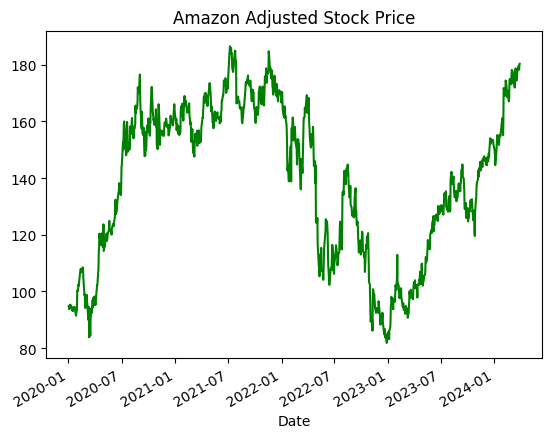

In [58]:
df2["Adj Close"].plot(title = "Amazon Adjusted Stock Price", color = "green")

Hurst exponent (H) is a measure for the long-term memory of a time series, that is, it measures the amount by which that series deviates from a random walk. The values of the Hurst exponent range between 0 and 1, with the following interpretation:

* H < 0.5—a series is mean-reverting. The closer the value is to 0, the stronger the mean-reversion process is. 
* H = 0.5—a series is a geometric random walk. 
* H > 0.5—a series is trending. The closer the value is to 1, the stronger the trend. 

There are a few ways of calculating the Hurst exponent. In this recipe, we will focus on the one based on estimating the rate of the diffusive behavior, which is based on the variance of log prices.

In [59]:
# Define a function calculating the Hurst exponent:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""

    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

The calculations of the Hurst exponent can be summarized in two steps:

For each lag in the considered range, we calculate the standard deviation of the differenced series. Calculate the slope of the log plot of lags versus the standard deviations to get the Hurst exponent.

In [60]:
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}");

Hurst exponent with 20 lags: 0.4816
Hurst exponent with 100 lags: 0.4725
Hurst exponent with 250 lags: 0.4995
Hurst exponent with 500 lags: 0.4372


Los valores son más cercanos a 0.5, por lo que se considera a la serie como una caminata aleatoria

## 2. Modelación con GBM (Geometric Brownian Motion)
Modelar la serie usando modelos estocásticos

Código inspirado en: https://blog.ms-researchhub.com/2021/11/27/modeling-asset-prices-with-geometric-brownian-motion-in-python/

In [61]:
import pmdarima
from sklearn.metrics import mean_absolute_percentage_error as mape

In [111]:
df2["log_rtn"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(1))
df2 = df2[["Adj Close", "log_rtn"]].dropna()
df2.head(5)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_25956\487191774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["log_rtn"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(1))
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be use

,Adj Close,log_rtn
Date,,
2020-01-03,93.748497,-0.012213
2020-01-06,95.143997,0.014776
2020-01-07,95.343002,0.002089
2020-01-08,94.598503,-0.007839
2020-01-09,95.052498,0.004788


In [63]:
train, test = pmdarima.model_selection.train_test_split(df2["Adj Close"].dropna(), train_size = 0.8)
training, testing = pmdarima.model_selection.train_test_split(df2["log_rtn"].dropna(), train_size = 0.8)

2024-04-12 10:00:49.418 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 120 seconds)
2024-04-12 10:00:55.623 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=4954.0518)
2024-04-12 10:01:05.425 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=4807.29988)
2024-04-12 10:01:10.770 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=3038.607712)
2024-04-12 10:01:22.449 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=3873.659912)
2024-04-12 10:01:26.841 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=335.66932)
2024-04-12 10:01:44.951 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=292.768112)
2024-04-12 10:01:48.243 | INFO     | fitter.fitter:_fit_single_distrib

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norminvgauss,98.864390,148.431616,167.421962,inf,0.012738,0.998854
johnsonsu,101.085611,143.029474,162.019820,inf,0.013820,0.996172
hypsecant,101.339564,189.434863,198.930036,inf,0.015598,0.983688
genhyperbolic,101.545512,144.039473,167.777406,inf,0.013758,0.996400
tukeylambda,103.066829,143.216270,157.459030,inf,0.019582,0.892992


d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_out

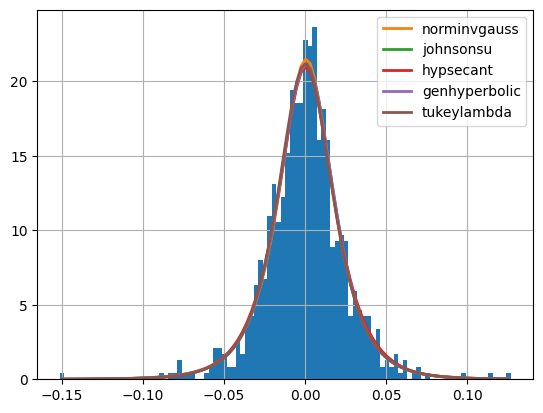

In [64]:
f = Fitter(training, timeout = 120)
f.fit()
f.summary()

In [65]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es el "bic", que se refiere al Criterio de Información Bayesiano.
f.get_best(method = "bic")

{'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}

In [66]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es el "sumsquare_error", que se refiere a la suma de los errores al cuadrado.
f.get_best(method = "sumsquare_error")

{'norminvgauss': {'a': 0.9753668732438454,
  'b': -0.026601118197388612,
  'loc': 0.0008819343939723866,
  'scale': 0.02405741263947861}}

In [67]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es 
f.get_best(method = "aic")

{'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}

Usando los modelos que fueron seleccionados como mejores (según su respectivo criterio), se procedió a realizar una predicción y con ello evaluar al modelo

### Norminvgauss distribution.

Encontrar el mejor modelo probando distintos hiperparámetros.

In [68]:
def GBMsimulatorUniVar_Normgauss(So, mu, sigma, T, N, a = 0.9753668732438454, b = -0.026601118197388612, scale = 0.02405741263947861, loc = 0.0008819343939723866):
    """ This methods uses random numbers to repeatedly sample future results – in our case, we sample 
    random numbers from a Uniform Distribution, then multiply them to our volatility to obtain our diffusion term."""
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.norminvgauss.rvs(a=a, b=b, scale = scale, loc = loc, random_state = 0)
            # Z = scipy.stats.laplace.rvs()
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]


In [69]:
# Create a pandas dataframe that saves the results of the model.
results_NIG = pd.DataFrame(columns = ["MAPE", "Scale", "Loc"]) 
results_NIG

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_out

,MAPE,Scale,Loc


In [70]:
# Iterating over the scale and loc parameters
# {{'norminvgauss': {'a': 0.9753668732438454, 'b': -0.026601118197388612, 'loc': 0.0008819343939723866, 'scale': 0.02405741263947861}}
# a > 0, |b| <= a
for scale in [1, 0.02405741263947861]:
    for loc in [0, 0.0008819343939723866]:
        prices = GBMsimulatorUniVar_Normgauss(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),  
                                         T = len(test), N = 1000, loc = loc, scale = scale)
        newpreds = pd.DataFrame(prices).mean(axis = 1)
        varMAPE = mape(newpreds, test.dropna())
        new_row_values = {"MAPE": varMAPE, "Scale": scale, "Loc": loc}
        results_NIG.loc[len(results_NIG)] = new_row_values

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_out

In [71]:
results_NIG.head(10)

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,MAPE,Scale,Loc
0,0.205882,1.000000,0.000000
1,0.207473,1.000000,0.000882
2,0.248215,0.024057,0.000000
3,0.245144,0.024057,0.000882


d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


El modelo con valores fijos $a = 0.9753668732438454$ y $b = -0.026601118197388612$ que tiene menor MAPE es aquel con los valores $scale = 1$ y $loc = 0$. En consecuencia, se procederá a usar estos parámetros para visualizar el rendimiento del modelo.

In [72]:
prices = GBMsimulatorUniVar_Normgauss(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),
                                      T = len(test), N = 1000, loc = 0, scale = 1)
newpreds = pd.DataFrame(prices).mean(axis = 1)
mape(newpreds, test.dropna())

0.20588170218620558

Taking the mean average prediction error (MAPE), we find around 20.58% forecasting error.

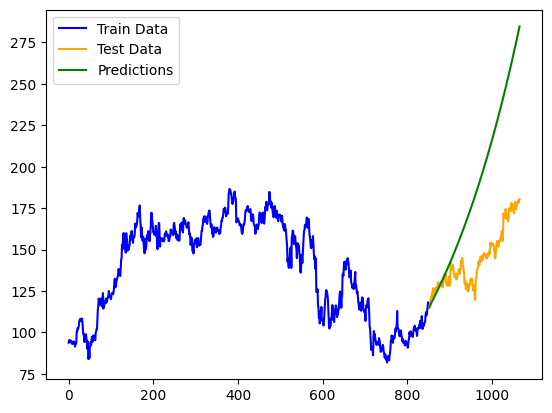

In [73]:
axis = np.arange(len(train) + len(test))
plt.plot(axis[:len(train)], train, c = "blue", label = "Train Data")
plt.plot(axis[len(train):], test, c = "orange", label = "Test Data")
plt.plot(axis[len(train):], np.array(newpreds), c = "green", label = "Predictions")
plt.legend()
plt.show();

### Uniform distribution.

Encontrar el mejor modelo probando distintos hiperparámetros.

In [74]:
def GBMsimulatorUniVar2_UNF(So, mu, sigma, T, N, loc = 0, scale = 1):
    """ This methods uses random numbers to repeatedly sample future results – in our case, we sample 
    random numbers from a Uniform Distribution, then multiply them to our volatility to obtain our diffusion term."""
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.uniform.rvs(scale =  scale, loc = loc, random_state = 0)
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]

In [75]:
# Create a pandas dataframe that saves the results of the model.
results_UNIF = pd.DataFrame(columns = ["MAPE", "Scale", "Loc"]) 
results_UNIF

,MAPE,Scale,Loc


In [76]:
# Iterating over the scale and loc parameters
# {'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}
for scale in [1, 0.2783468286451102]:
    for loc in [0, -0.15139791287665294]:
        prices = GBMsimulatorUniVar2_UNF(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),  
                                             T = len(test), N = 1000, loc = loc, scale = scale)
        newpreds = pd.DataFrame(prices).mean(axis = 1)
        varMAPE = mape(newpreds, test.dropna())
        new_row_values = {"MAPE": varMAPE, "Scale": scale, "Loc": loc}
        results_UNIF.loc[len(results_UNIF)] = new_row_values

In [77]:
results_UNIF.head(10)

,MAPE,Scale,Loc
0,0.619272,1.000000,0.000000
1,0.502912,1.000000,-0.151398
2,0.163199,0.278347,0.000000
3,0.258277,0.278347,-0.151398


El modelo que tiene menor MAPE es aquel con los valores scale = 0.2783 y loc = 0. En consecuencia, se procederá a usar estos parámetros para visualizar el rendimiento del modelo.

In [78]:
prices = GBMsimulatorUniVar2_UNF(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(), T = len(test), N = 1000,
                                 loc = 0, scale = 0.278347)
newpreds = pd.DataFrame(prices).mean(axis = 1)
mape(newpreds, test.dropna())

0.16319907421306312

Taking the mean average prediction error (MAPE), we find around 16.31% forecasting error.

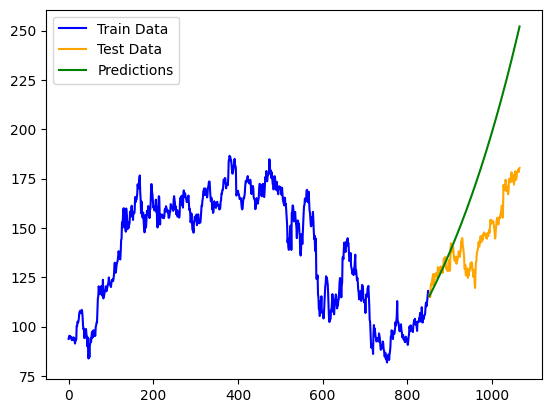

In [79]:
# Agregar una legenda a cada gráfico.
axis = np.arange(len(train) + len(test))
plt.plot(axis[:len(train)], train, c = "blue", label = "Train Data")
plt.plot(axis[len(train):], test, c = "orange", label = "Test Data")
plt.plot(axis[len(train):], np.array(newpreds), c = "green", label = "Predictions")
plt.legend()
plt.show();

## 3. Mejora del modelo

In [146]:
import jumpdiff as jd
from numpy import random as rn
from scipy import stats
import scipy.stats as si
import seaborn as sns
G = 1629562571
np.random.seed(G) 
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

El modelo se puede mejorar usando un modelo más complejo, usando “poisson jumps” para simular alzas y bajas de la serie. 
Código basado en: https://medium.com/@polanitzer/jump-diffusion-process-with-drift-in-python-simulate-the-future-distribution-of-foreign-exchange-3d448e6f1d95

Primero se deben obtener los valores correspondientes de los siguientes parámetros:
* S0 : The variable’s today value (a.k.a starting value)
* T : The forecast horizon (years)
* μ : The annualized growth or drift rate
* σ : The annualized volatility
* λ : The jump rate of S
* θ : The jump size of S
* M : The number of Monte Carlo simulations
* N : the number of steps

### The Financial Approach for Estimating the GBM Process Parameters

In [147]:
df2.reset_index(inplace = True)
df2 = df2[["Date","Adj Close", "log_rtn"]]
df2.head(5)

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integra

,Date,Adj Close,log_rtn
0,2020-01-03,93.748497,-0.012213
1,2020-01-06,95.143997,0.014776
2,2020-01-07,95.343002,0.002089
3,2020-01-08,94.598503,-0.007839
4,2020-01-09,95.052498,0.004788


In [148]:
# Let’s create a new column for the relative returns
df2["Return"] = 0.00
for i in range(0,len(df2.index) - 1):
    # df1["Return"][i] = df1["Price"][i+1]/df1["Price"][i]-1
    df2["Return"][i] = df2["Adj Close"][i+1]/df2["Adj Close"][i]-1
df2.head(5)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_25956\934757671.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2["Return"][i] = df2["Adj Close"][i+1]/df2["Adj Close"][i]-1
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\

C:\Users\Usuario\AppData\Local\Temp\ipykernel_25956\934757671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Return"][i] = df2["Adj Close"][i+1]/df2["Adj Close"][i]-1
C:\Users\Usuario\AppData\Local\Temp\ipykernel_25956\934757671.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead,

,Date,Adj Close,log_rtn,Return
0,2020-01-03,93.748497,-0.012213,0.014886
1,2020-01-06,95.143997,0.014776,0.002092
2,2020-01-07,95.343002,0.002089,-0.007809
3,2020-01-08,94.598503,-0.007839,0.004799
4,2020-01-09,95.052498,0.004788,-0.009411


In [149]:
mu = df2["Return"].mean()
print("The monthly drift rate as the average of all the relative returns is:", "{:.4%}".format(mu))

The monthly drift rate as the average of all the relative returns is: 0.0887%


In [150]:
sigma = df2["Return"].std()
print("The monthly volatility rate as the standard deviation of all the relative returns is:", "{:.4%}".format(sigma))

The monthly volatility rate as the standard deviation of all the relative returns is: 2.3396%


### Jump rate and jump size

In [151]:
X = df2["Adj Close"]
edges, moments = jd.moments(timeseries = X)

In [152]:
lamb_est = jd.jump_rate(moments = moments)
lamb_est

array([42.43188456])

### Set the model's parameters.

In [153]:
S0 = df2["Adj Close"].iloc[-1] # The variable’s today value (a.k.a starting value)

μ = 0.0008 # The annualized growth or drift rate
σ = 0.0234 # The annualized volatility

# Valores arbitrarios para la simulación
T = 5.0 # The forecast horizon (years)
M = 50000 # The number of Monte Carlo simulations
N = 100 # the number of steps

# The jump size θ can be found by computing the ratio of the post-jump to the pre-jump levels
λ = 0.05 # The jump rate of S
θ = 1.1 # the jump size of S

### Metrics

Let’s build metrics for the future values and the random drawings

In [154]:
ε = rn.randn(M,N)
F_λ = rn.poisson(λ,(M,N))
S = S0*np.ones((M,N+1))
dt = T/N

### Model

In [155]:
start_time = datetime.now() 
for i in range(0,N):
    S[:,i+1] = S[:,i]*(1 + θ*F_λ[:,i]*dt + μ*dt + σ*ε[:,i]*np.sqrt(dt) )

### Visualization

Let’s visualize the model results for 8 paths

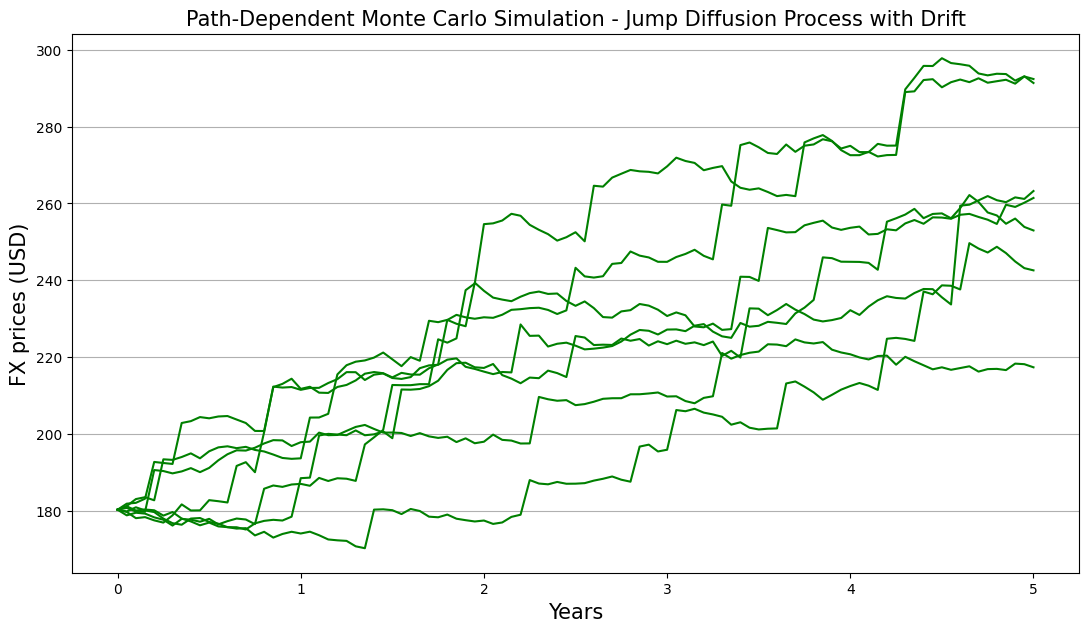

In [156]:
plt.figure(figsize=(13,7))
fontsize=15
plt.title('Path-Dependent Monte Carlo Simulation - Jump Diffusion Process with Drift',fontsize=fontsize)
plt.xlabel('Years',fontsize=fontsize)
plt.ylabel('FX prices (USD)',fontsize=fontsize)
plt.grid(axis='y')
a = [ rn.randint(0,M) for j in range(1,8)]
for runer in a:
    plt.plot(np.arange(0,T+dt,dt), S[runer], 'green')

### Results

In [157]:
V = (S[:,-1])
print("\033[1m The estimate of the future value is ${:.2f}".format(np.mean(V)))
print("\033[1m The accuracy of the estimate is ${:.2f}".format((np.std(V)/np.sqrt(M))))

 The estimate of the future value is $238.07
 The accuracy of the estimate is $0.14


#### Intrinsic Value property outputs

In [178]:
time_elapsed = datetime.now() - start_time
def NORMSINV(x):
    x = si.norm.ppf(x)
    return (x)
Workbook_Name = "Jump Diffusion with Drift.ipynb"
Number_of_Steps = "{:,.0f}".format(N)
Number_of_Iterations = "{:,.0f}".format(M)
Number_of_Inputs = "{:,.0f}".format(6)
Number_of_Outputs = 1
Sampling_Type = "Latin Hypercube"
Simulation_Start_Time = dt_string
Simulation_Duration = '{}'.format(time_elapsed)
Random_N_Generator = 'Mersenne Twister'
e = ['Workbook Name','Number of Steps','Number of Iterations','Number of Inputs','Number of Outputs','Sampling Type',\
 'Simulation Start Time','Simulation Duration','Random # Generator']
f = [Workbook_Name, Number_of_Steps, Number_of_Iterations, Number_of_Inputs, Number_of_Outputs, Sampling_Type,\
 Simulation_Start_Time, Simulation_Duration, Random_N_Generator]
Per5 = "{:,.1f}".format(np.percentile(V, 5))
P5 = "{:.0%}".format(0.05)
Per10 = "{:,.1f}".format(np.percentile(V, 10))
P10 = "{:.0%}".format(0.10)
Per15 = "{:,.1f}".format(np.percentile(V, 15))
P15 = "{:.0%}".format(0.15)
Per20 = "{:,.1f}".format(np.percentile(V, 20))
P20 = "{:.0%}".format(0.20)
Per25 = "{:,.1f}".format(np.percentile(V, 25))
P25 = "{:.0%}".format(0.25)
Per30 = "{:,.1f}".format(np.percentile(V, 30))
P30 = "{:.0%}".format(0.30)
Per35 = "{:,.1f}".format(np.percentile(V, 35))
P35 = "{:.0%}".format(0.35)
Per40 = "{:,.1f}".format(np.percentile(V, 40))
P40 = "{:.0%}".format(0.40)
Per45 = "{:,.1f}".format(np.percentile(V, 45))
P45 = "{:.0%}".format(0.45)
Per50 = "{:,.1f}".format(np.percentile(V, 50))
P50 = "{:.0%}".format(0.50)
Per55 = "{:,.1f}".format(np.percentile(V, 55))
P55 = "{:.0%}".format(0.55)
Per60 = "{:,.1f}".format(np.percentile(V, 60))
P60 = "{:.0%}".format(0.60)
Per65 = "{:,.1f}".format(np.percentile(V, 65))
P65 = "{:.0%}".format(0.65)
Per70 = "{:,.1f}".format(np.percentile(V, 70))
P70 = "{:.0%}".format(0.70)
Per75 = "{:,.1f}".format(np.percentile(V, 75))
P75 = "{:.0%}".format(0.75)
Per80 = "{:,.1f}".format(np.percentile(V, 80))
P80 = "{:.0%}".format(0.80)
Per85 = "{:,.1f}".format(np.percentile(V, 85))
P85 = "{:.0%}".format(0.85)
Per90 = "{:,.1f}".format(np.percentile(V, 90))
P90 = "{:.0%}".format(0.90)
Per95 = "{:,.1f}".format(np.percentile(V, 95))
P95 = "{:.0%}".format(0.95)
Minimum = "{:,.1f}".format(np.min(V))
Maximum = "{:,.1f}".format(np.max(V))
Mean = "{:,.1f}".format(np.mean(V))
Std_Dev = "{:,.1f}".format(np.std(V))
Variance = int(np.var(V))
Std_Error = "{:,.1f}".format(np.std(V)/np.sqrt(M))
Skewness = round(stats.skew(V),9)
Kurtosis = round((stats.kurtosis(V)+3),9)
Median = "{:,.1f}".format(np.median(V))
Mode = "{:,.1f}".format(stats.mode(V)[0])
Left_X = Per5
Left_P = P5
Right_X = Per95
Right_P = P95
Diff_X = "{:,.1f}".format((np.percentile(V, 95) - np.percentile(V, 5)))
Diff_P = "{:.0%}".format(0.90)
Confidence_Level = P95
Lower_Bound = "{:,.1f}".format((np.mean(V) - (np.std(V)/np.sqrt(M))*NORMSINV(0.975)))
Upper_Bound = "{:,.1f}".format((np.mean(V) + (np.std(V)/np.sqrt(M))*NORMSINV(0.975)))
g = {'Information': e, 'Result': f}
st = pd.DataFrame(data=g)
a = ['Minimum','Maximum','Mean','Std Dev','Variance','Std Error', 'Skewness','Kurtosis','Median','Mode',\
 'Left X','Left P','Right X','Right P','Diff X','Diff P','Confidence Level','Lower 95.0%','Upper 95.0%']
b = [Minimum, Maximum, Mean, Std_Dev, Variance, Std_Error, Skewness, Kurtosis, Median, Mode, Left_X, Left_P,\
 Right_X, Right_P, Diff_X, Diff_P, Confidence_Level, Lower_Bound, Upper_Bound]
c = [P5,P10,P15,P20,P25,P30,P35,P40,P45,P50,P55,P60,P65,P70,P75,P80,P85,P90,P95]
d = [Per5, Per10, Per15, Per20, Per25, Per30, Per35, Per40, Per45, Per50, Per55, Per60, Per65,\
 Per70, Per75, Per80, Per85, Per90, Per95]
d = {'Statistics': a, 'Statistics Result': b, 'Percentile': c, 'Percentile Result': d}
st1 = pd.DataFrame(data=d)
from datetime import date
today = date.today()
now = datetime.now()
import calendar
curr_date = date.today()
print("\033[1m Simulation Summary Information")
print("\033[0m ================================================")
print("\033[1m Date:","\033[0m",calendar.day_name[curr_date.weekday()],",",today.strftime("%B %d, %Y"),",",now.strftime("%H:%M:%S AM"))
print(st)

 Simulation Summary Information
 Date:  Friday , April 12, 2024 , 13:05:01 AM
             Information                           Result
0          Workbook Name  Jump Diffusion with Drift.ipynb
1        Number of Steps                              100
2   Number of Iterations                           50,000
3       Number of Inputs                                6
4      Number of Outputs                                1
5          Sampling Type                  Latin Hypercube
6  Simulation Start Time              12/04/2024 12:55:58
7    Simulation Duration                   0:08:46.055018
8     Random # Generator                 Mersenne Twister


In [179]:
print("\033[1m Summary Statistics for Future Value")
print("\033[0m ======================================================")
print("\033[1m Date:","\033[0m",calendar.day_name[curr_date.weekday()],",",today.strftime("%B %d, %Y"),",",now.strftime("%H:%M:%S AM"));
st1

 Summary Statistics for Future Value
 Date:  Friday , April 12, 2024 , 13:05:01 AM


,Statistics,Statistics Result,Percentile,Percentile Result
0,Minimum,157.0,5%,192.9
1,Maximum,474.5,10%,200.7
2,Mean,238.1,15%,206.4
3,Std Dev,31.7,20%,211.2
4,Variance,1002,25%,215.6
5,Std Error,0.1,30%,219.5
6,Skewness,0.74183,35%,223.3
7,Kurtosis,4.045777,40%,227.0
8,Median,234.6,45%,230.8
9,Mode,157.0,50%,234.6


 Probability Density Function for Future Value
 Date:  Friday , April 12, 2024 , 13:05:01 AM


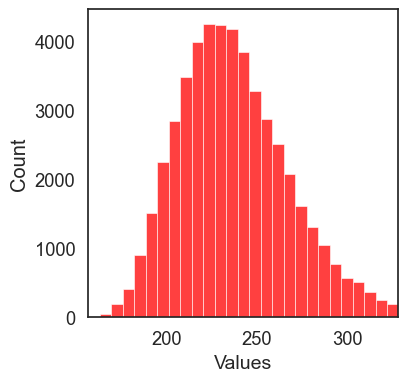

In [180]:
plt.figure(figsize = (4,4))
sns.set(font_scale = 1.2)
sns.set_style('white')
ax = sns.histplot(data=V,bins=50,color='red')
ax.set_xlabel('Values',fontsize=14)
ax.set_xlim( np.percentile(V, 0) , np.percentile(V, 99) )
print("\033[1m Probability Density Function for Future Value")
print("\033[0m ======================================================")
print("\033[1m Date:","\033[0m",calendar.day_name[curr_date.weekday()],",",today.strftime("%B %d, %Y"),",",now.strftime("%H:%M:%S AM"));


 Cumulative Distribution Function for Future Value
 Date:  Friday , April 12, 2024 , 13:05:01 AM


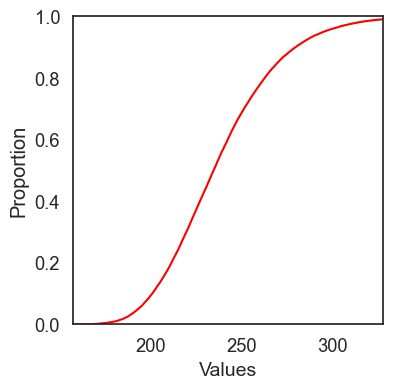

d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\Cristian\Profesional\8vo Semestre\proyectos-ingenieria\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_out

In [181]:
plt.figure(figsize = (4,4))
kwargs = {'cumulative': True}
sns.set(font_scale = 1.2)
sns.set_style('white')
ax = sns.ecdfplot(V, color='red')
ax.set_xlabel('Values',fontsize=14)
ax.set_xlim( np.percentile(V, 0) , np.percentile(V, 99) )
print("\033[1m Cumulative Distribution Function for Future Value")
print("\033[0m ======================================================")
print("\033[1m Date:","\033[0m",calendar.day_name[curr_date.weekday()],",",today.strftime("%B %d, %Y"),",",now.strftime("%H:%M:%S AM"));
